In [10]:
!export https_proxy=http://127.0.0.1:33210 http_proxy=http://127.0.0.1:33210 all_proxy=socks5://127.0.0.1:33211

'export' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [4]:
!set HTTP_PROXY=http://127.0.0.1:33210
!set HTTPS_PROXY=http://127.0.0.1:33210

In [ ]:
!pip install -U "huggingface_hub[cli]"

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install ipywidgets

In [ ]:
!pip install accelerate

In [1]:
import torch
import transformers

print(torch.__version__)
print(torch.cuda.is_available())
print(transformers.__version__)

2.5.1+cu121
True
4.56.0.dev0


In [ ]:
!hf auth whoami

In [4]:
import os
# 设置模型下载位置（修改为您的路径）
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

# 设置环境变量
os.environ['HF_HOME'] = MODEL_DIR


In [5]:
os.environ["HF_HOME"]

'./models'

In [ ]:
from transformers import pipeline
from transformers.image_utils import load_image
from torchvision import transforms
import numpy as np
from PIL import Image


url = "img/test.png"

image = load_image(url)

feature_extractor = pipeline(
    model="./models/dinov3-vith16plus-pretrain-lvd1689m",
    task="image-feature-extraction",
)
features = feature_extractor(image)

Device set to use cuda:0


In [7]:
features = torch.tensor(features)

In [8]:
features, features.shape, image.size,

(tensor([[[-0.5841, -0.0603, -0.3001,  ...,  0.1044,  0.1770, -0.2476],
          [-0.2349, -0.0711,  0.1269,  ...,  0.2936,  0.2839,  0.1783],
          [-0.0269,  0.1028, -0.0218,  ...,  0.1253,  0.0653,  0.0728],
          ...,
          [-0.3756, -0.1465,  0.1082,  ..., -0.0834,  0.0774,  0.1949],
          [-0.2901, -0.0458,  0.1211,  ..., -0.0756,  0.0886,  0.0971],
          [-0.3097, -0.0681,  0.1399,  ..., -0.0858,  0.0734,  0.0967]]]),
 torch.Size([1, 16389, 1280]),
 (640, 480))

1个全局的CLS token，4个 register tokens，

In [9]:
features_no_batch = features.squeeze(0)

In [10]:
features_no_batch.shape

torch.Size([16389, 1280])

In [11]:
import math
num_tokens = features_no_batch.shape[0]
num_patches_guess = int(math.sqrt(num_tokens))**2
h = w = int(math.sqrt(num_patches_guess))
num_special_tokens = num_tokens - num_patches_guess
patch_features = features_no_batch[num_special_tokens:, :]

In [12]:
num_tokens, num_patches_guess, h, num_special_tokens, patch_features.shape, patch_features

(16389,
 16384,
 128,
 5,
 torch.Size([16384, 1280]),
 tensor([[-0.1421, -0.1482, -0.0256,  ..., -0.0024, -0.0130,  0.3180],
         [-0.1269, -0.2026, -0.0598,  ..., -0.0263, -0.0870,  0.2852],
         [-0.1352, -0.2397, -0.0251,  ..., -0.0699, -0.1656,  0.2725],
         ...,
         [-0.3756, -0.1465,  0.1082,  ..., -0.0834,  0.0774,  0.1949],
         [-0.2901, -0.0458,  0.1211,  ..., -0.0756,  0.0886,  0.0971],
         [-0.3097, -0.0681,  0.1399,  ..., -0.0858,  0.0734,  0.0967]]))

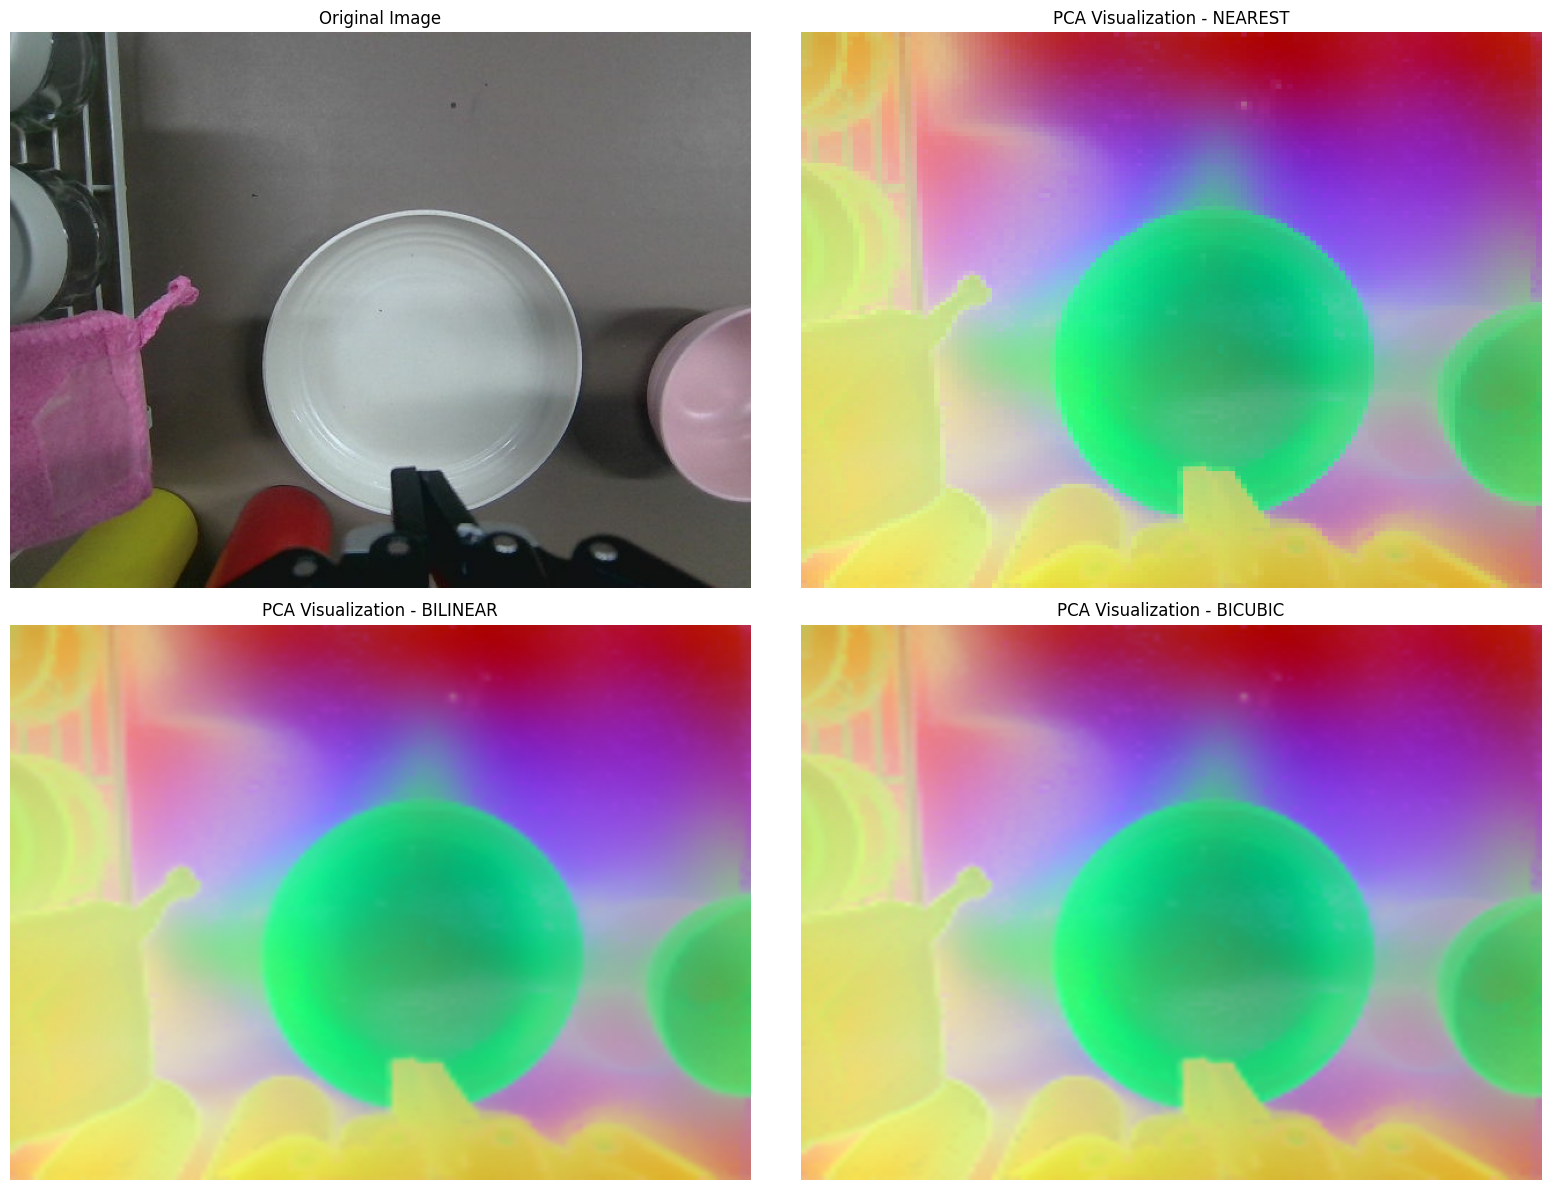

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

pca = PCA(n_components=3)
features_pca = pca.fit_transform(patch_features.numpy())

pca_image = features_pca.reshape((h, w, 3))

pca_image_normalized = np.zeros_like(pca_image)
for i in range(3):
    channel = pca_image[:, :, i]
    pca_image_normalized[:, :, i] = (channel - channel.min()) / (channel.max() - channel.min())

pca_pil_image = Image.fromarray((pca_image_normalized * 255).astype(np.uint8))

pca_pil_image_nearest = pca_pil_image.resize(image.size, Image.Resampling.NEAREST)
pca_pil_image_bilinear = pca_pil_image.resize(image.size, Image.Resampling.BILINEAR)
pca_pil_image_bicubic = pca_pil_image.resize(image.size, Image.Resampling.BICUBIC)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

# NEAREST 插值
axes[0, 1].imshow(pca_pil_image_nearest)
axes[0, 1].set_title("PCA Visualization - NEAREST")
axes[0, 1].axis('off')

# BILINEAR 插值
axes[1, 0].imshow(pca_pil_image_bilinear)
axes[1, 0].set_title("PCA Visualization - BILINEAR")
axes[1, 0].axis('off')

# BICUBIC 插值
axes[1, 1].imshow(pca_pil_image_bicubic)
axes[1, 1].set_title("PCA Visualization - BICUBIC")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [14]:
pca_pil_image_nearest.size

(640, 480)